# Main Functions 

Welcome to MacroDensity's tutorial Jupyter Notebook. This notebook contains a few examples of how MacroDensity's basic functions are used. 

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import macrodensity as md

import ase.io.cube

## Plotting the planar and macroscopic average 
``MacroDensity`` is able to calculate the planar and macroscopic potential average of a material. The code below illustrates that:

### Post-procesing `CHGCAR` file

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  8.000000069794417
Average of the average =  7.72953392288895


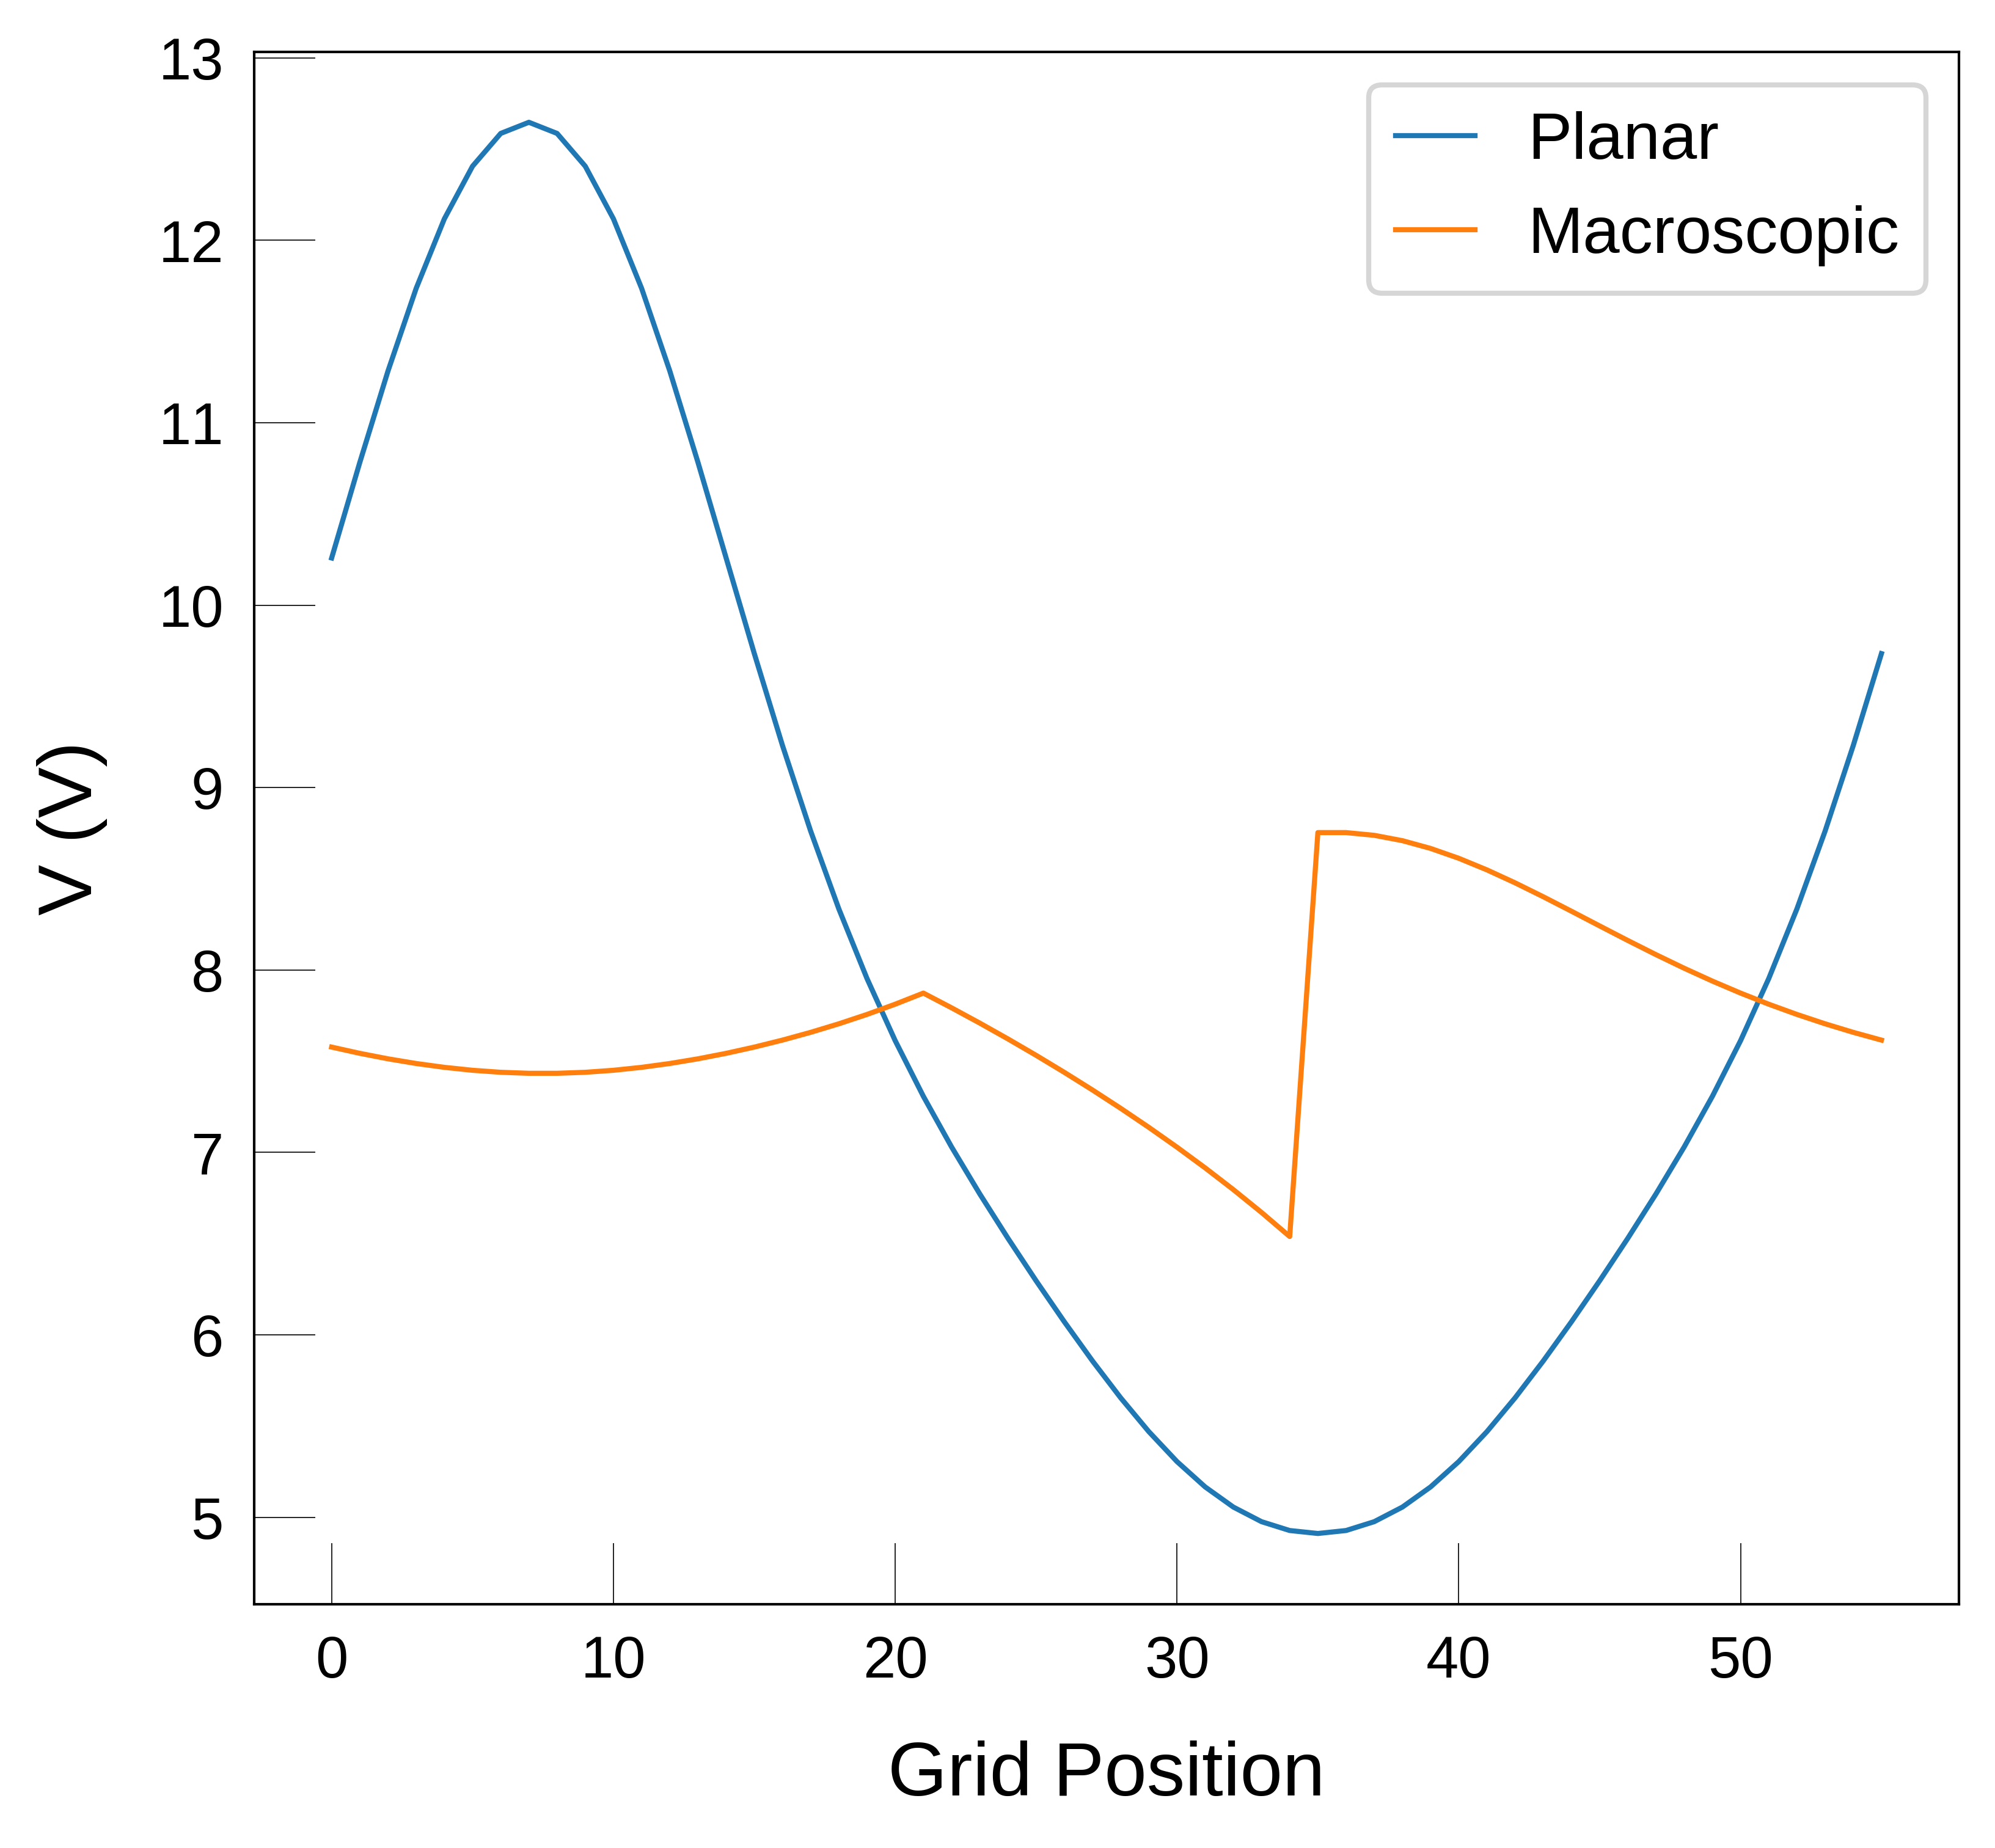

In [2]:
# Using the VASP CHGCAR file:
planar, macro, fig = md.plot_planar_average(
    input_file='CHGCAR.test',
    lattice_vector=4.8,
)

### Post-processing the `LOCPOT` file

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13
Average of the average =  -0.07045532018119124


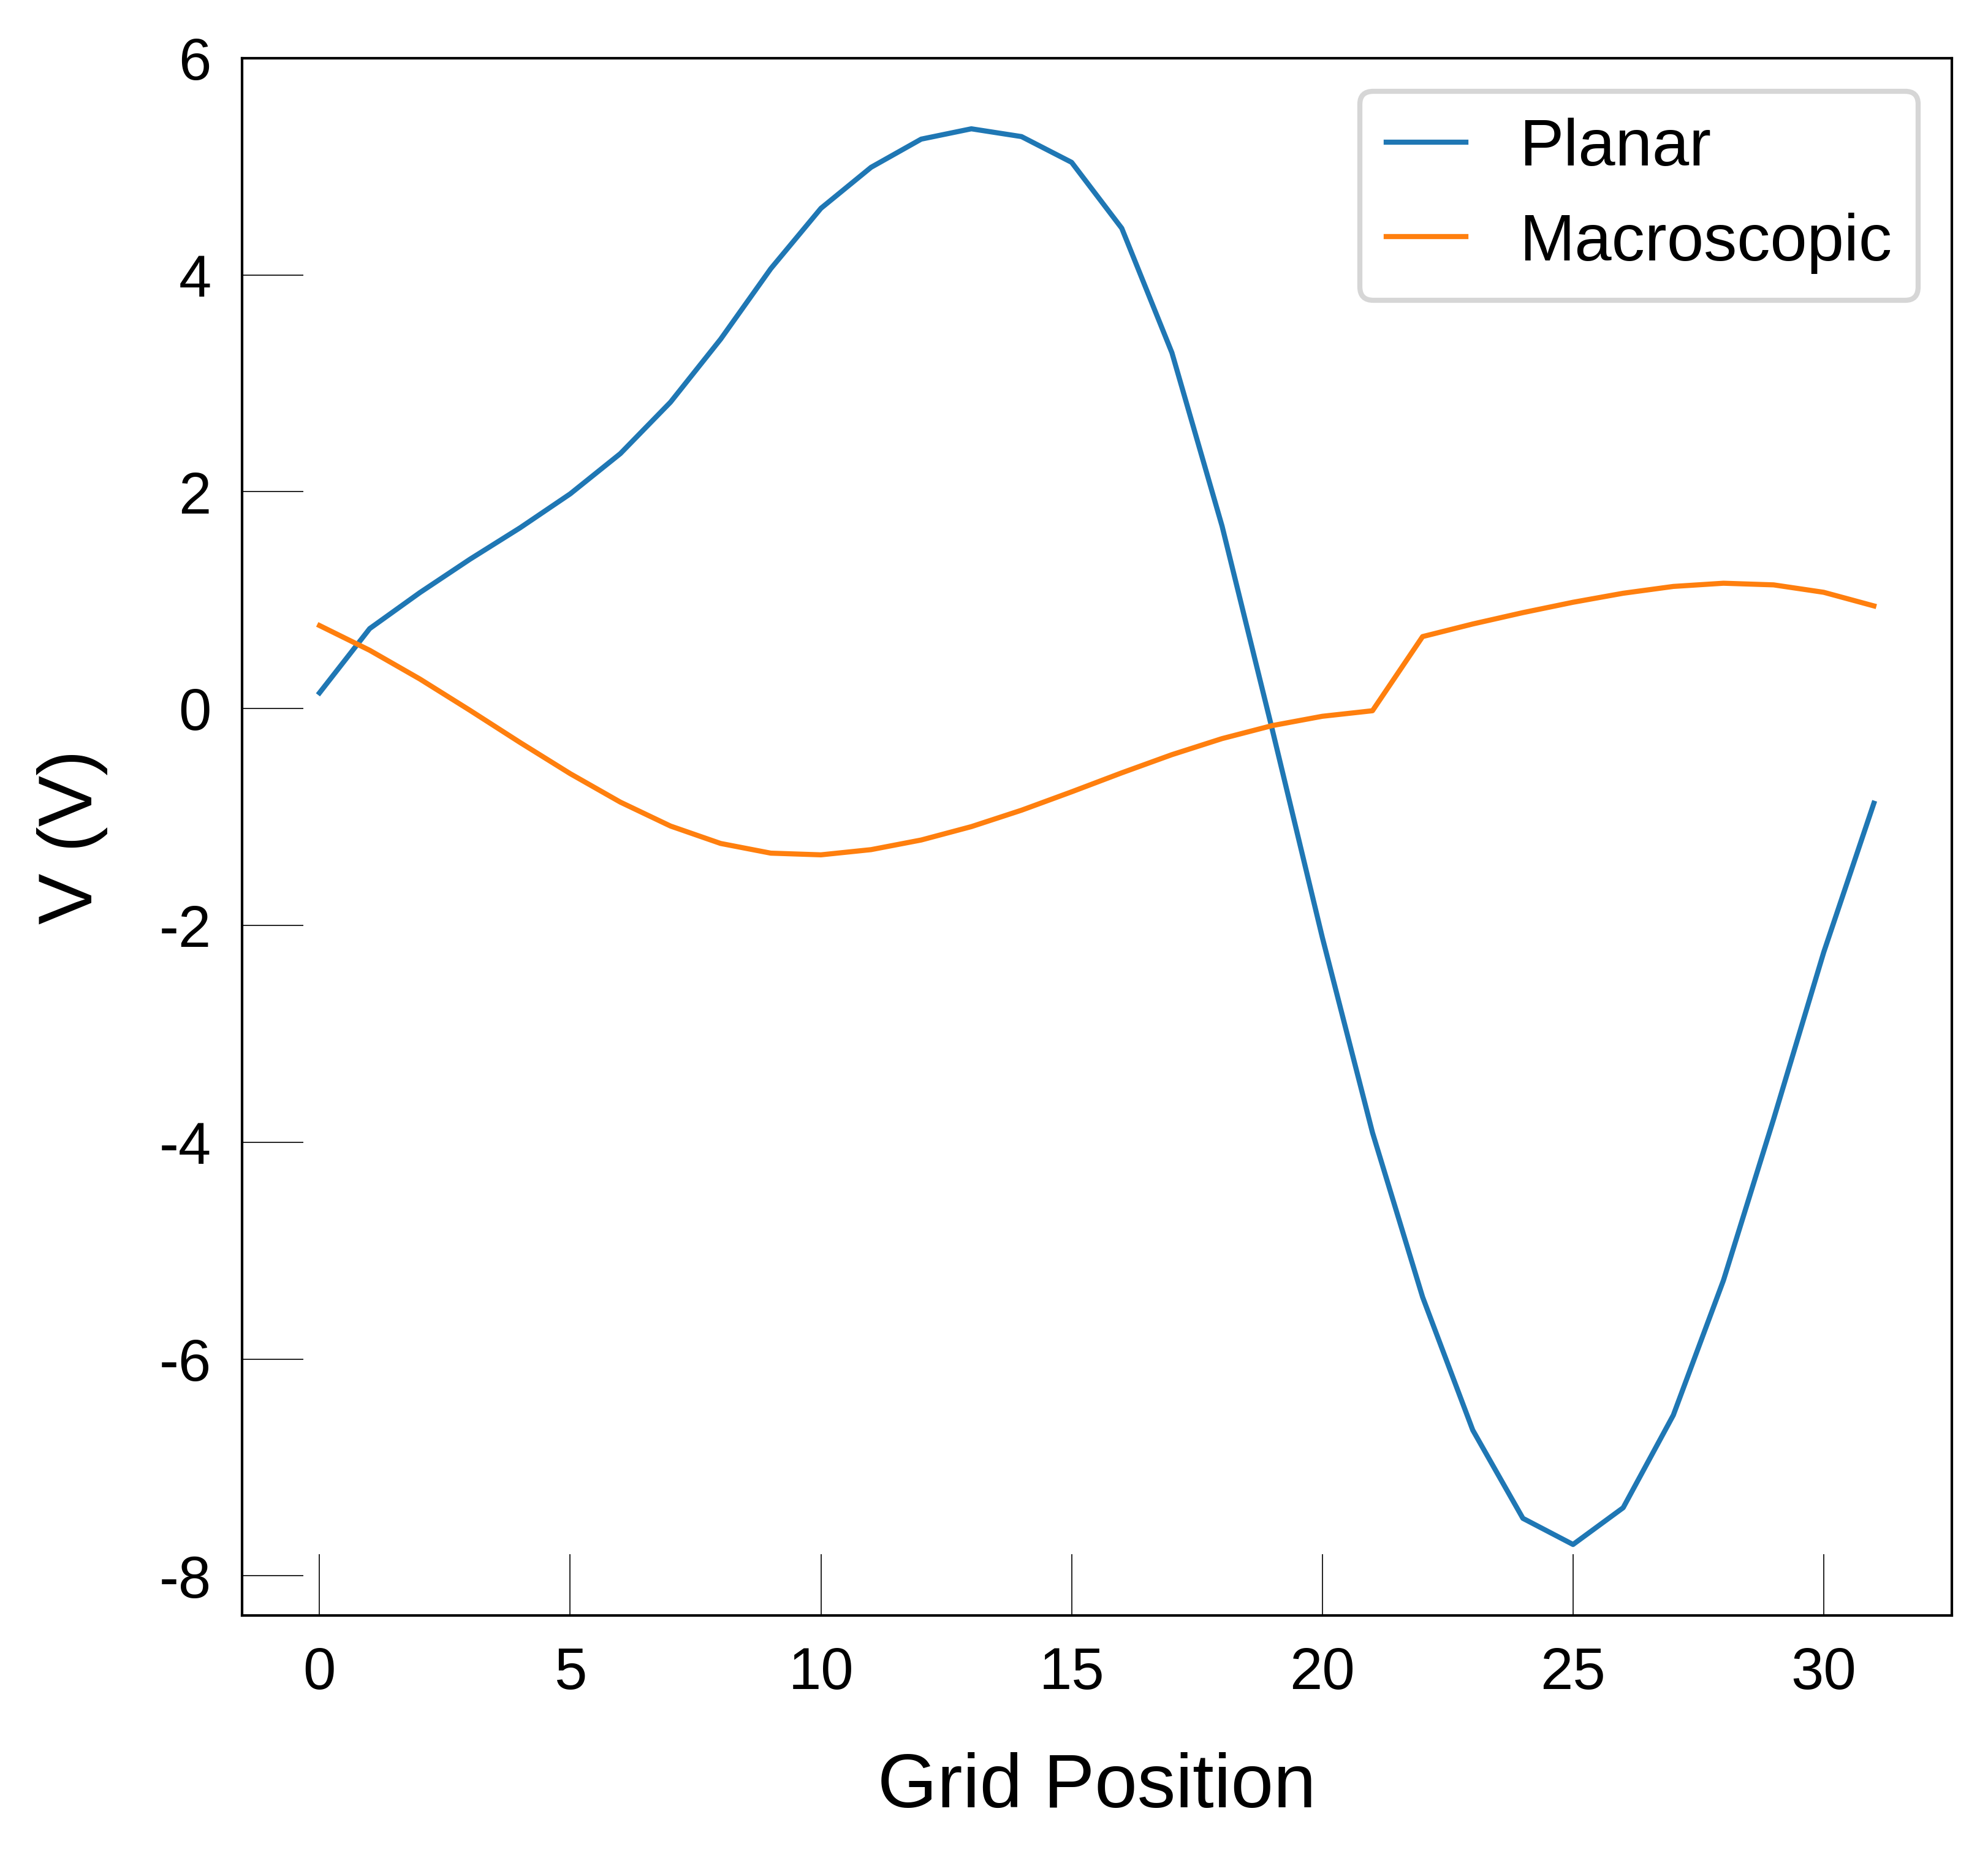

In [5]:
input_file = 'LOCPOT.test'
lattice_vector = 5.41
output_file = 'PlanarAverage.csv'
img_file = 'PlanarAverage.png'

planar, macro, fig = md.plot_planar_average(lattice_vector, input_file, output_file, img_file)

### Post-processing a `cube` file

Average of the average =  0.004323820372140808


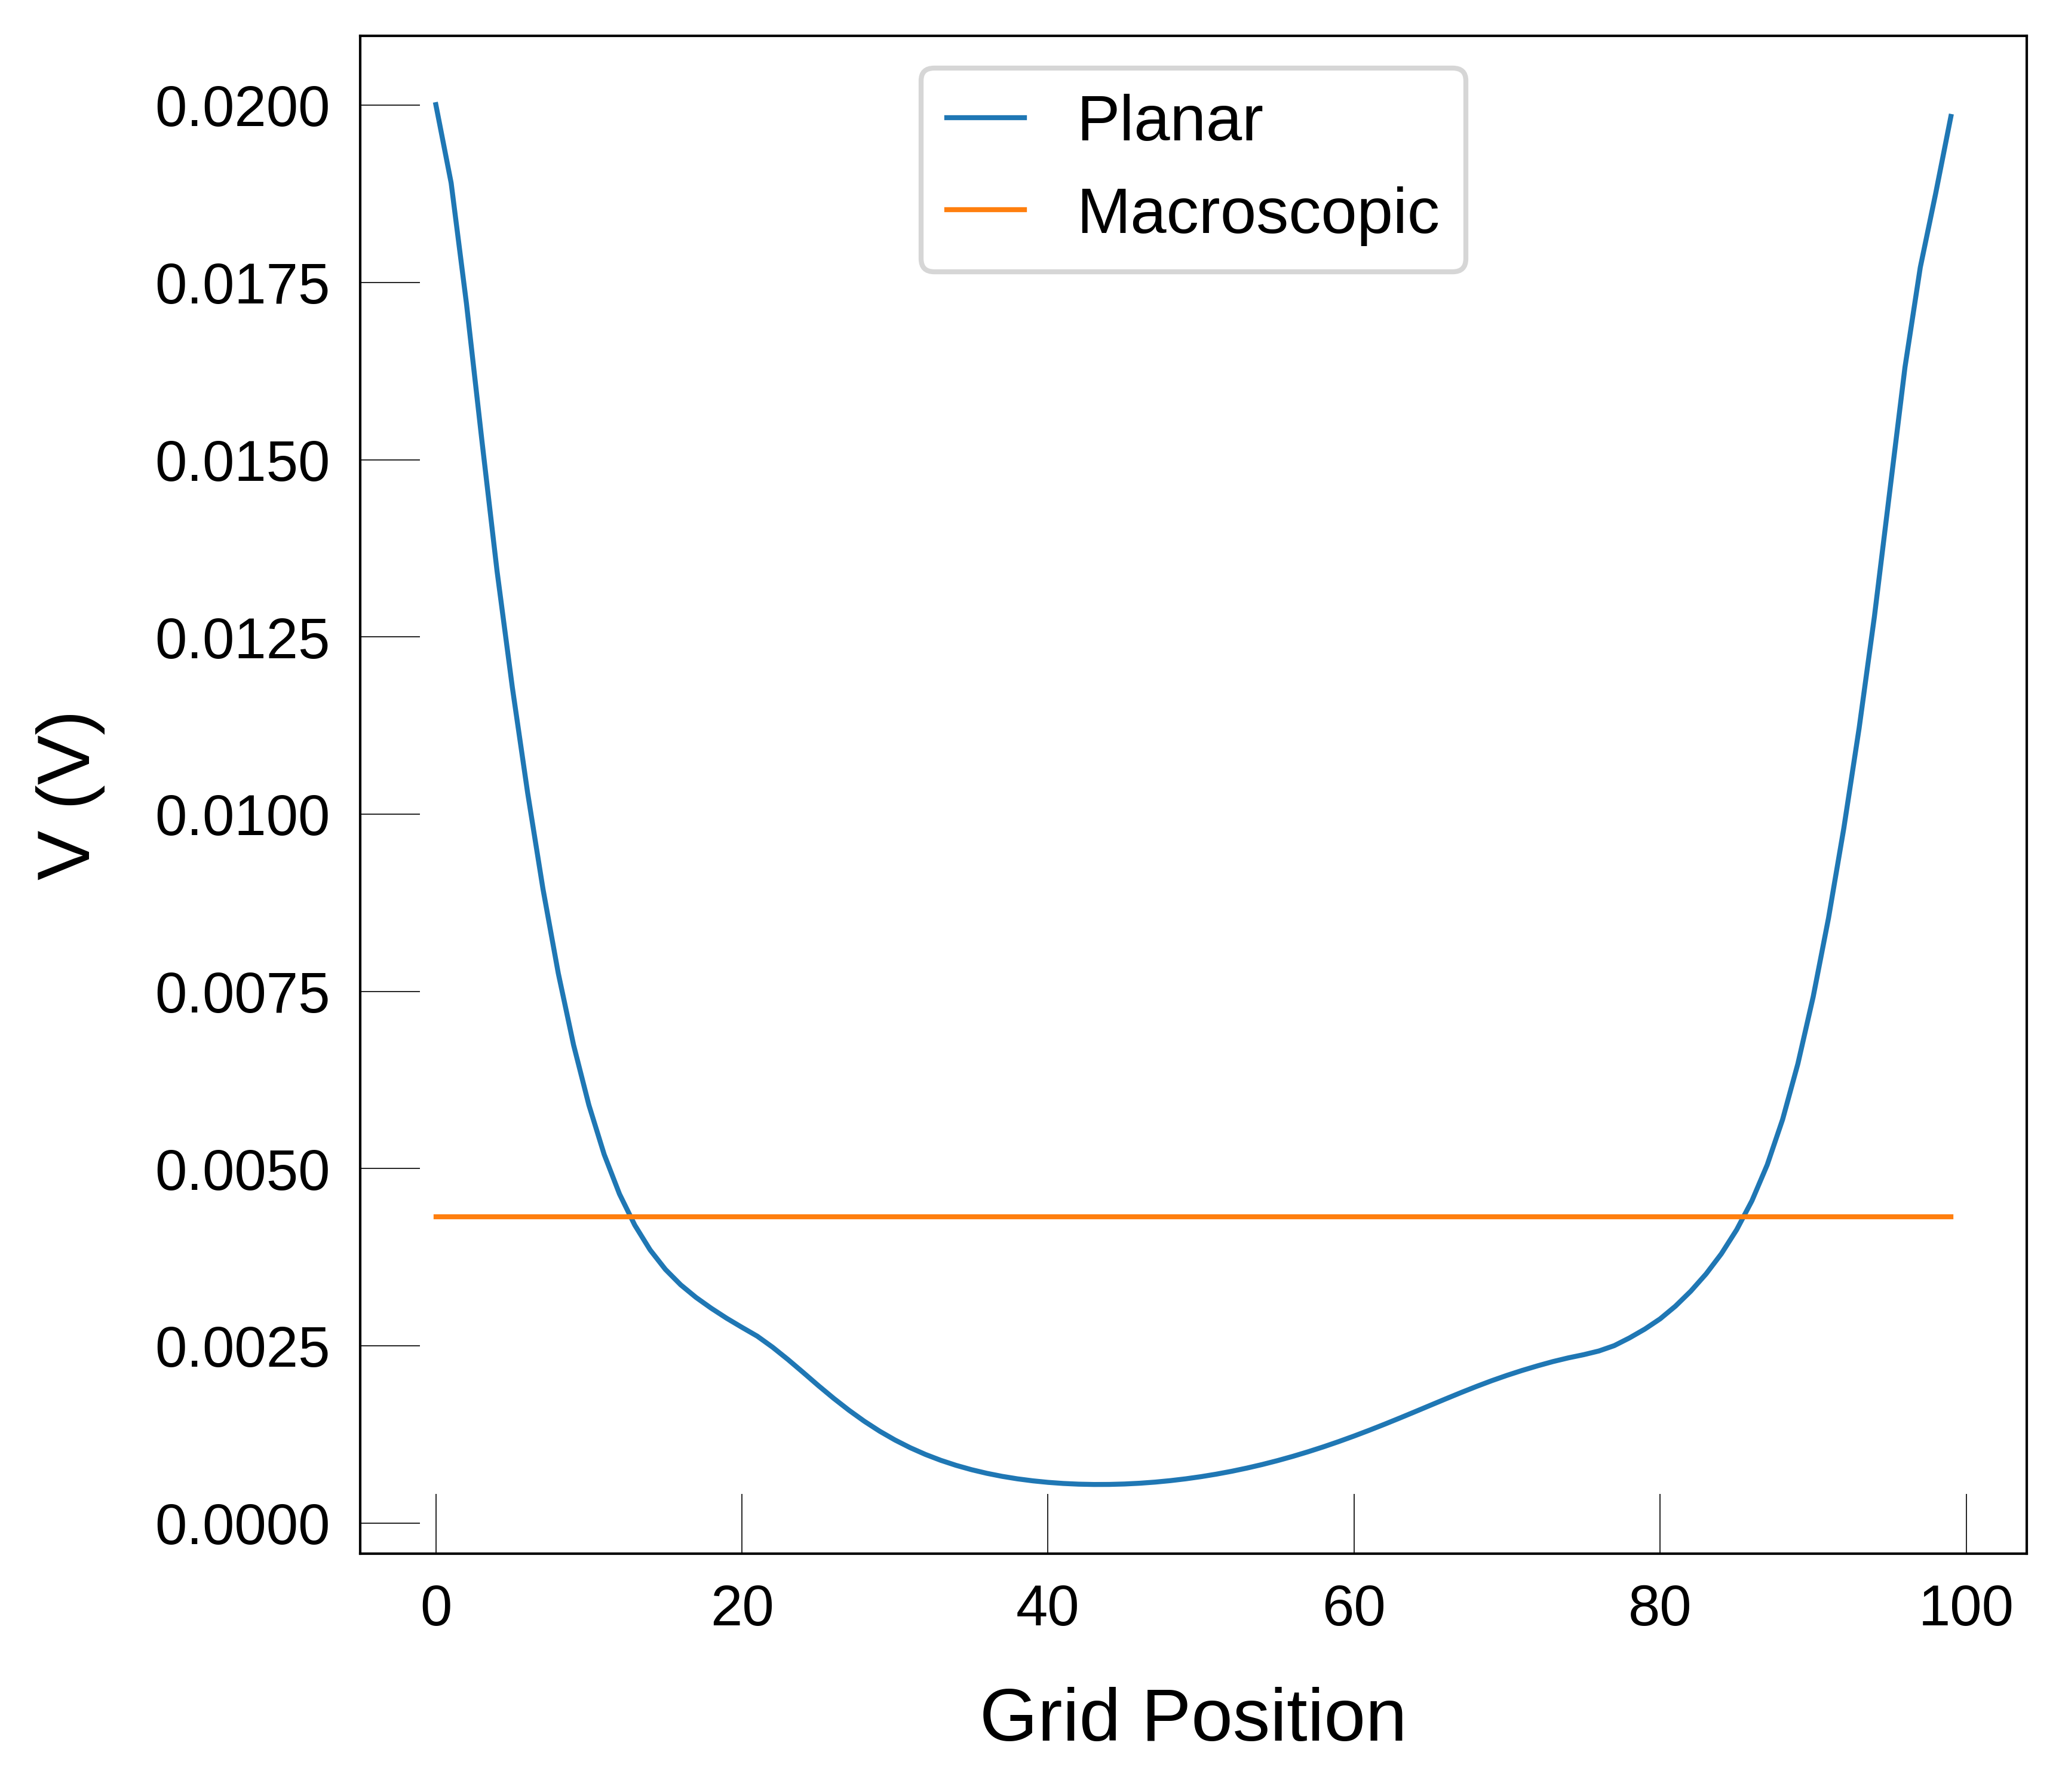

In [4]:
input_file = "cube_001_spin_density.cube"
lattice_vector = 4.75
output_file = 'PlanarCube.csv'
img_file = 'PlanarCube.png'

planar, macro, fig = md.plot_planar_average(
    lattice_vector=lattice_vector, 
    input_file=input_file, 
    output_file=output_file, 
    img_file=img_file
)

## Distinguishing plateau regions in the electrostatic potential
The code below aims to detect plateau regions in the electrostatic potential of a material. It takes inputs such as cube size, cube origin in fractional unit cell coordinates, a tolerance threshold for identifying plateaus, and an input `VASP LOCPOT` filename. The output is the percentage of cubes categorized as non-vacuum versus vacuum, providing insight into areas of consistent potential within the material.

### Getting potential values 

In [10]:
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot, NGX, NGY, NGZ)
cutoff_varience = tolerance
grad_x, grad_y, grad_z = np.gradient(grid_pot[:,:,:], resolution_x, resolution_y, resolution_z)
travelled = [0,0,0]

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


### Distinguishing between vaccuum and non-vaccuum cubes 

In [11]:
vacuum = []
non_vacuum = []
for i in range(0,NGX,cube_size[0]):
    for j in range(0,NGY,cube_size[1]):
        for k in range(0,NGZ,cube_size[2]):
            sub_origin = [float(i)/NGX,float(j)/NGY,float(k)/NGZ]
            cube_pot, cube_var = md.volume_average(origin=sub_origin,cube=cube_size,grid=grid_pot,nx=NGX,ny=NGY,nz=NGZ,travelled=[0,0,0])
            if cube_var <= cutoff_varience:
                vacuum.append(sub_origin)
            else:
                non_vacuum.append(sub_origin)
                
print("Number of vacuum cubes: ", len(vacuum))
print("Number of non-vacuum cubes: ", len(non_vacuum))
print("Percentage of vacuum cubes: ",(float(len(vacuum))/(float(len(vacuum))+float(len(non_vacuum)))*100.))
print("Percentage of non-vacuum cubes: ",(float(len(non_vacuum))/(float(len(vacuum))+float(len(non_vacuum)))*100.))

Number of vacuum cubes:  17
Number of non-vacuum cubes:  4079
Percentage of vacuum cubes:  0.4150390625
Percentage of non-vacuum cubes:  99.5849609375


## Aligning band edged to reference potentials
The code below deals with aligning band edges to the reference potential within interstitial regions of a material. Input parameters include the positions of interstitial spaces, the `VASP OUTCAR` and `LOCPOT` filenames, and the size of a cube defined by `LOCPOT` FFT mesh points. The function's output consists of the aligned valence band, aligned conduction band, and variances within the interstitial regions.

### Input Section

In [12]:
interstices = ([0.5,0.5,0.5], [0.25,0.25,0.25])
outcar = 'OUTCAR.test'
locpot = 'LOCPOT.test'
cube_size = [2,2,2]

### Getting potential values and band edges 

In [13]:
# GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(locpot, quiet=True)
vector_a, vector_b, vector_c, av, bv, cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot, NGX, NGY, NGZ)

# GETTING BAND EDGES
band_extrema = md.get_band_extrema(outcar)
VB_eigenvalue = band_extrema[0]
CB_eigenvalue = band_extrema[1]

Reading header information...
Reading 3D data using Pandas...


### Calculating reference states and the aligned band energies 

In [16]:
## CALCULATING REFERENCE STATE
interstitial_potentials = []
interstitial_variances = []
for interstice in interstices:
    locpot_extract = md.volume_average(
        origin=interstice,
        cube=cube_size,
        grid=grid_pot,
        nx=NGX,
        ny=NGY,
        nz=NGZ
    )
    interstitial_potentials.append(locpot_extract[0])
    interstitial_variances.append(locpot_extract[1])

## CALCULATING ALIGNED BAND ENERGIES
sum_interstitial_potential = 0
for ele in interstitial_potentials:
    sum_interstitial_potential += ele
average_interstitial_potential = sum_interstitial_potential/len(interstitial_potentials)
VB_aligned = round(VB_eigenvalue - average_interstitial_potential,2)
CB_aligned = round(CB_eigenvalue - average_interstitial_potential,2)

## PRINTING
print("Reading band edges from file: " + str(outcar))
print("Reading potential from file: " + str(locpot))
print("Interstital variances: " + str(interstitial_variances))
print("VB_aligned (eV)      CB_aligned (eV)")
print("--------------------------------")
print(VB_aligned, "             ", CB_aligned)


Reading band edges from file: OUTCAR.test
Reading potential from file: LOCPOT.test
Interstital variances: [1.8665165271901357e-05, 6.277207757909537e-06]
VB_aligned (eV)      CB_aligned (eV)
--------------------------------
-3.24               -1.72


## Plotting variation of potential and magnitude of electric field 
The provided code processes `VASP`-calculated electrostatic potential and field magnitude data. It reads potential and lattice vectors from a file, calculates gradients, and analyzes a specified cubic region. Depending on the choice, it can plot potential or field magnitude. The plotted data can be saved to `ElectricField.csv`, and additionally, the field magnitude data is stored in binary format as `ElectricField.dat`.

### Initialising inputs 

In [18]:
import csv 

# Get the potential and the lattice vectors
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density('LOCPOT.test')
vector_a, vector_b, vector_c, av, bv, cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
grad_x, grad_y, grad_z = np.gradient(grid_pot[:,:,:],resolution_x,resolution_y,resolution_z)

cube = [2,2,2]
vector = [1,1,0]
origin = [0.5,0,0.5]
magnitude = 280

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


### Getting the potentials and field magnitudes

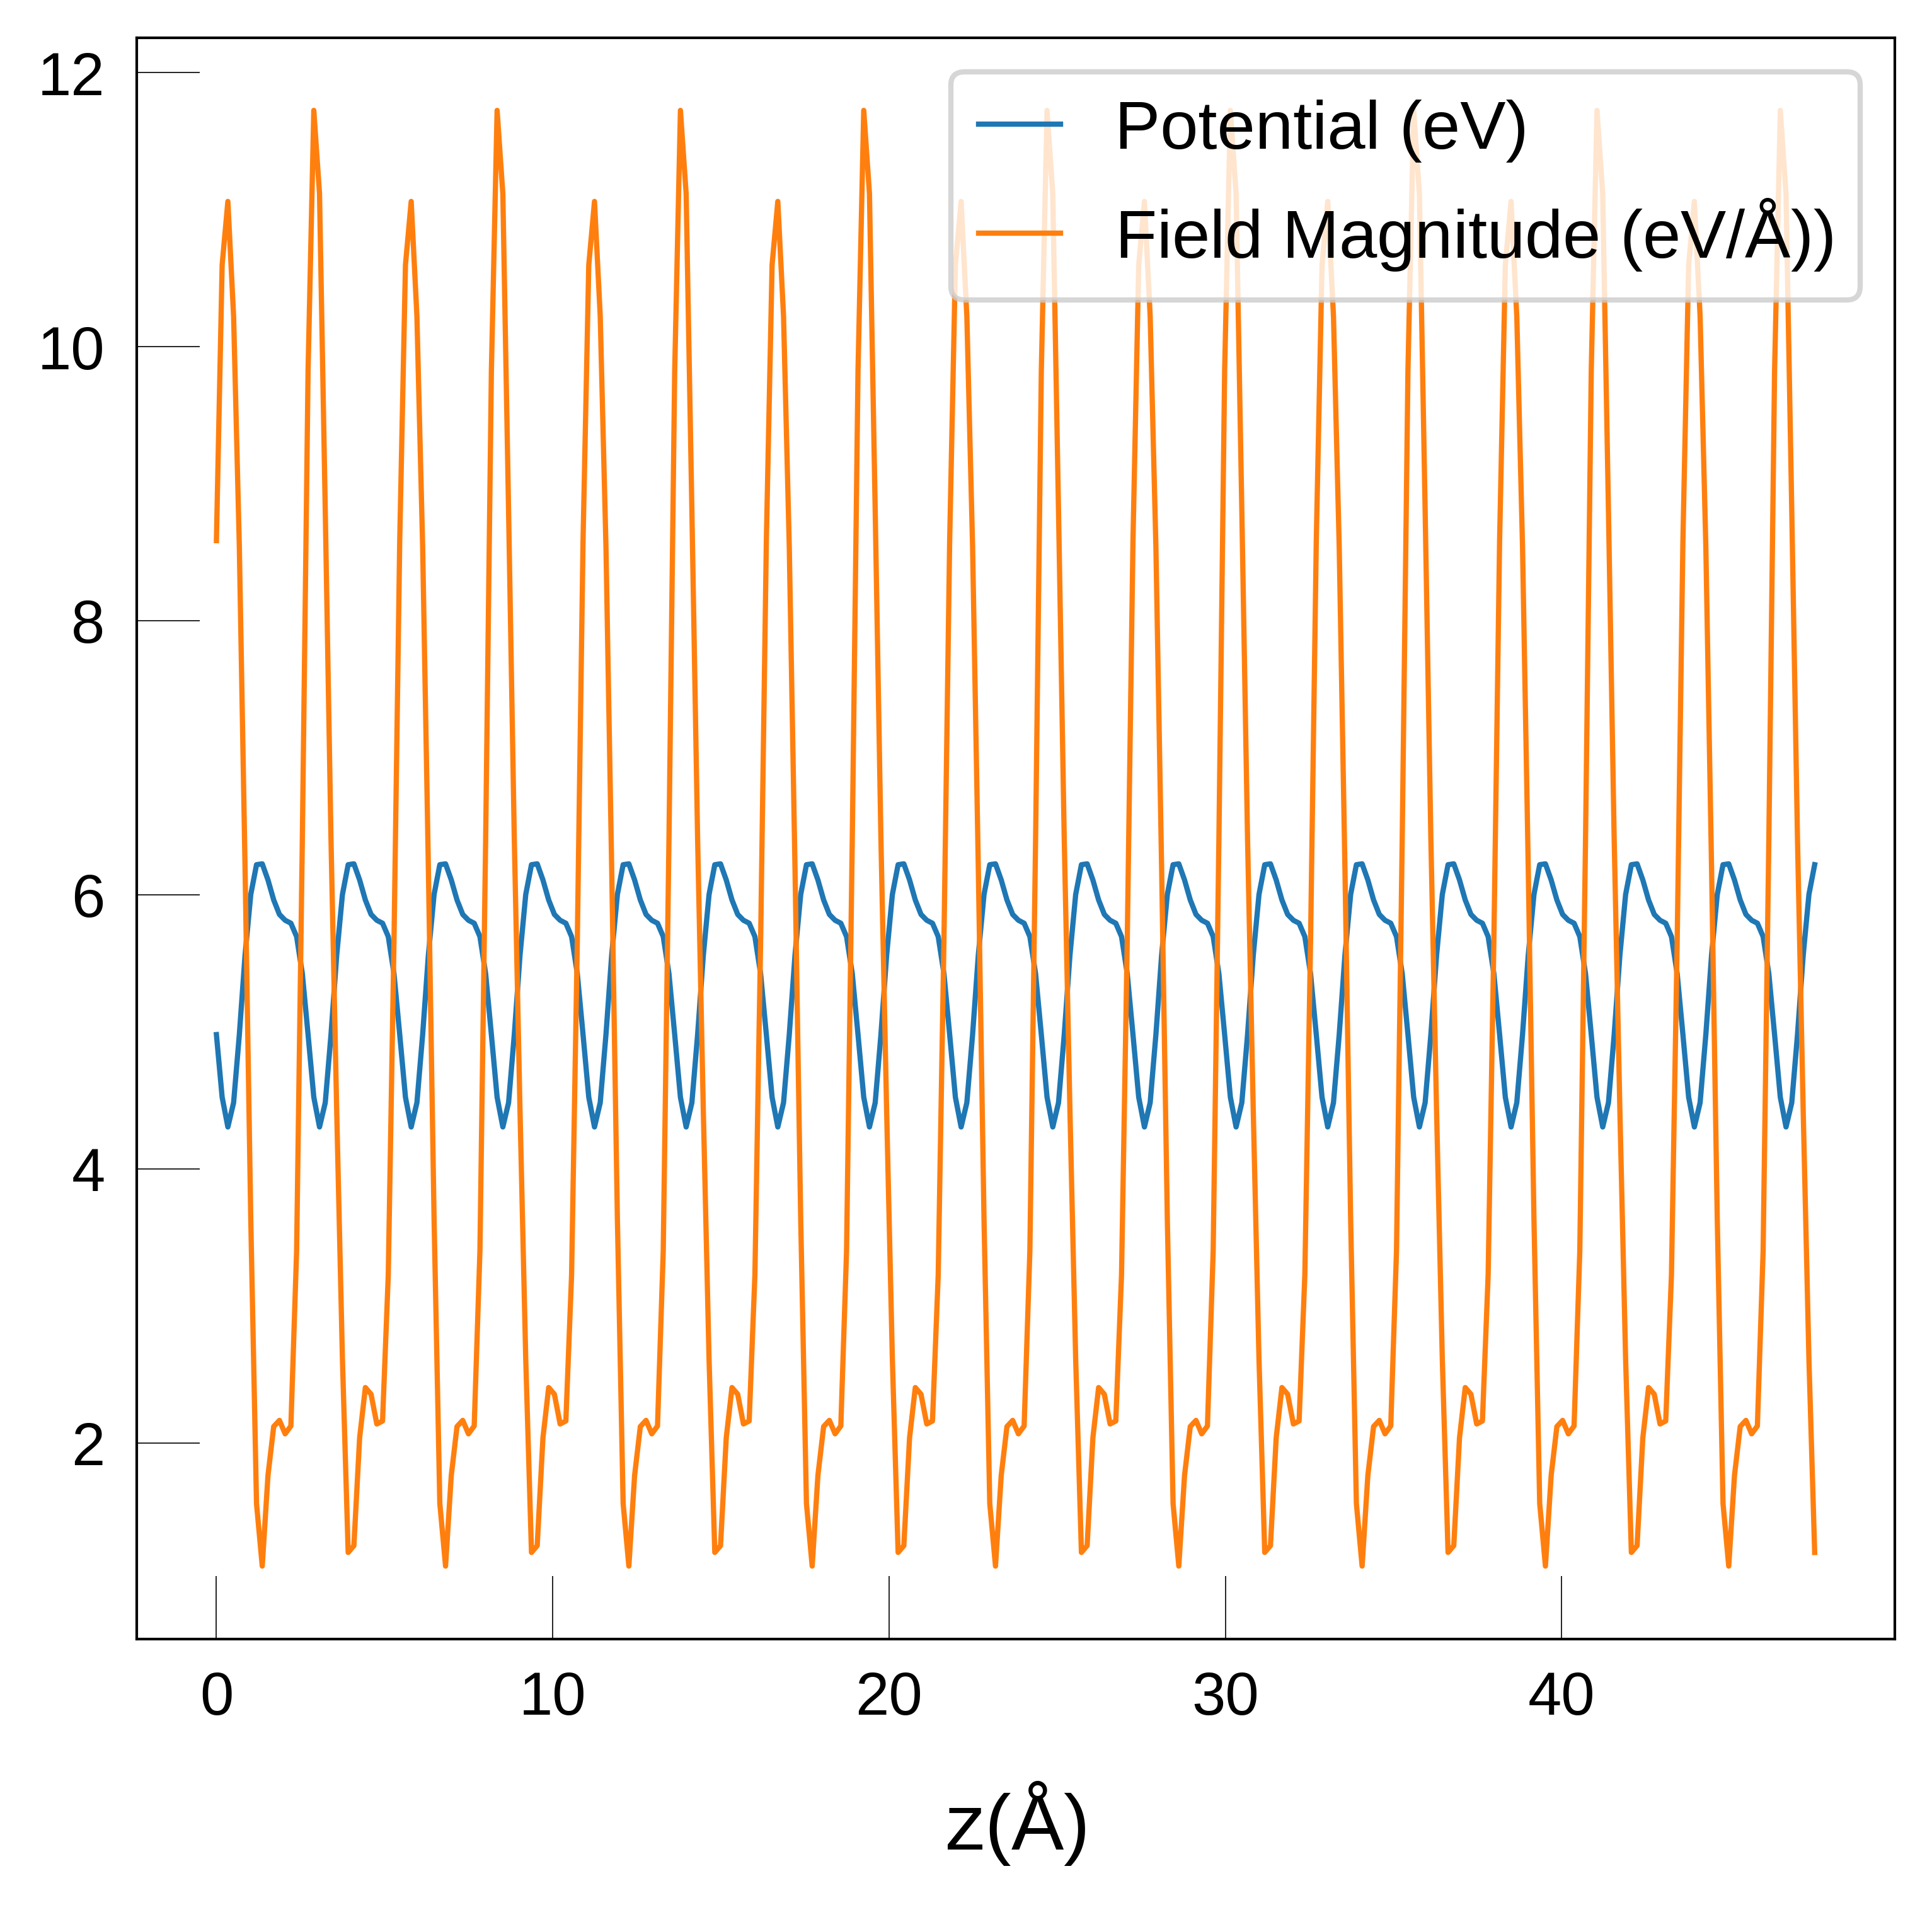

In [20]:
# Getting the potential and plotting it
cubes_potential = md.travelling_volume_average(grid_pot,cube,origin,vector,NGX,NGY,NGZ,magnitude)
abscissa = md.vector_2_abscissa(vector,magnitude,resolution_x,resolution_y,resolution_z)
plt.plot(abscissa, cubes_potential)
plt.xlabel("$z (\AA)$")


## Getting the field and plotting it
grad_mag = md.gradient_magnitude(grad_x,grad_y,grad_z)
cubes_field = md.travelling_volume_average(grad_mag,cube,origin,vector,NGX,NGY,NGZ,magnitude)
abscissa = md.vector_2_abscissa(vector,magnitude,resolution_x,resolution_y,resolution_z)
plt.plot(abscissa, cubes_field)
plt.xlabel("$z (\AA)$")
plt.legend(["Potential (eV)", "Field Magnitude (eV/$\AA$))"], frameon=True)

### Saving the data into a .csv and .dat (binary file)

In [22]:
import pandas as pd
## Save the data to a file
with open('ElectricField.csv','w')as f:
    writer = csv.writer(f)
    writer.writerow(['abscissa', 'cubes_field']) 
    for row in zip(abscissa, cubes_field):
        writer.writerow(row)

temp = pd.read_csv('ElectricField.csv', sep=',')    
np.asarray(temp.values).tofile('ElectricField.dat')

## Moving Cube 
Another notable function from ``MacroDensiity`` is the moving cube function. The code below generates an electrostatic potential plot that spans a specified vector across the unit cell. Inputs include cube size, origin, traversal vector, magnitude, input file, output data file name, and image file name. Outputs consist of an averaged electrostatic potential plot for the given cube size (as a list), a .csv file with the potential data, and a .png image displaying the potential plot.

![](./movingcube.gif)

### Input section 

In [25]:
cube = [1,1,1]
origin = [0.17,0.17,0.17]
vector = [1,1,1]
magnitude = 16
input_file = 'LOCPOT.test'
output_file ='MovingCube.csv'
img_file ='MovingCube.png'

### Getting the potential values along a vector 

In [23]:
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
cubes_potential = md.travelling_volume_average(grid_pot,cube,origin,vector,NGX,NGY,NGZ,magnitude)
abscissa = md.vector_2_abscissa(vector,magnitude,resolution_x,resolution_y,resolution_z)

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


### Plotting and Saving the graph 

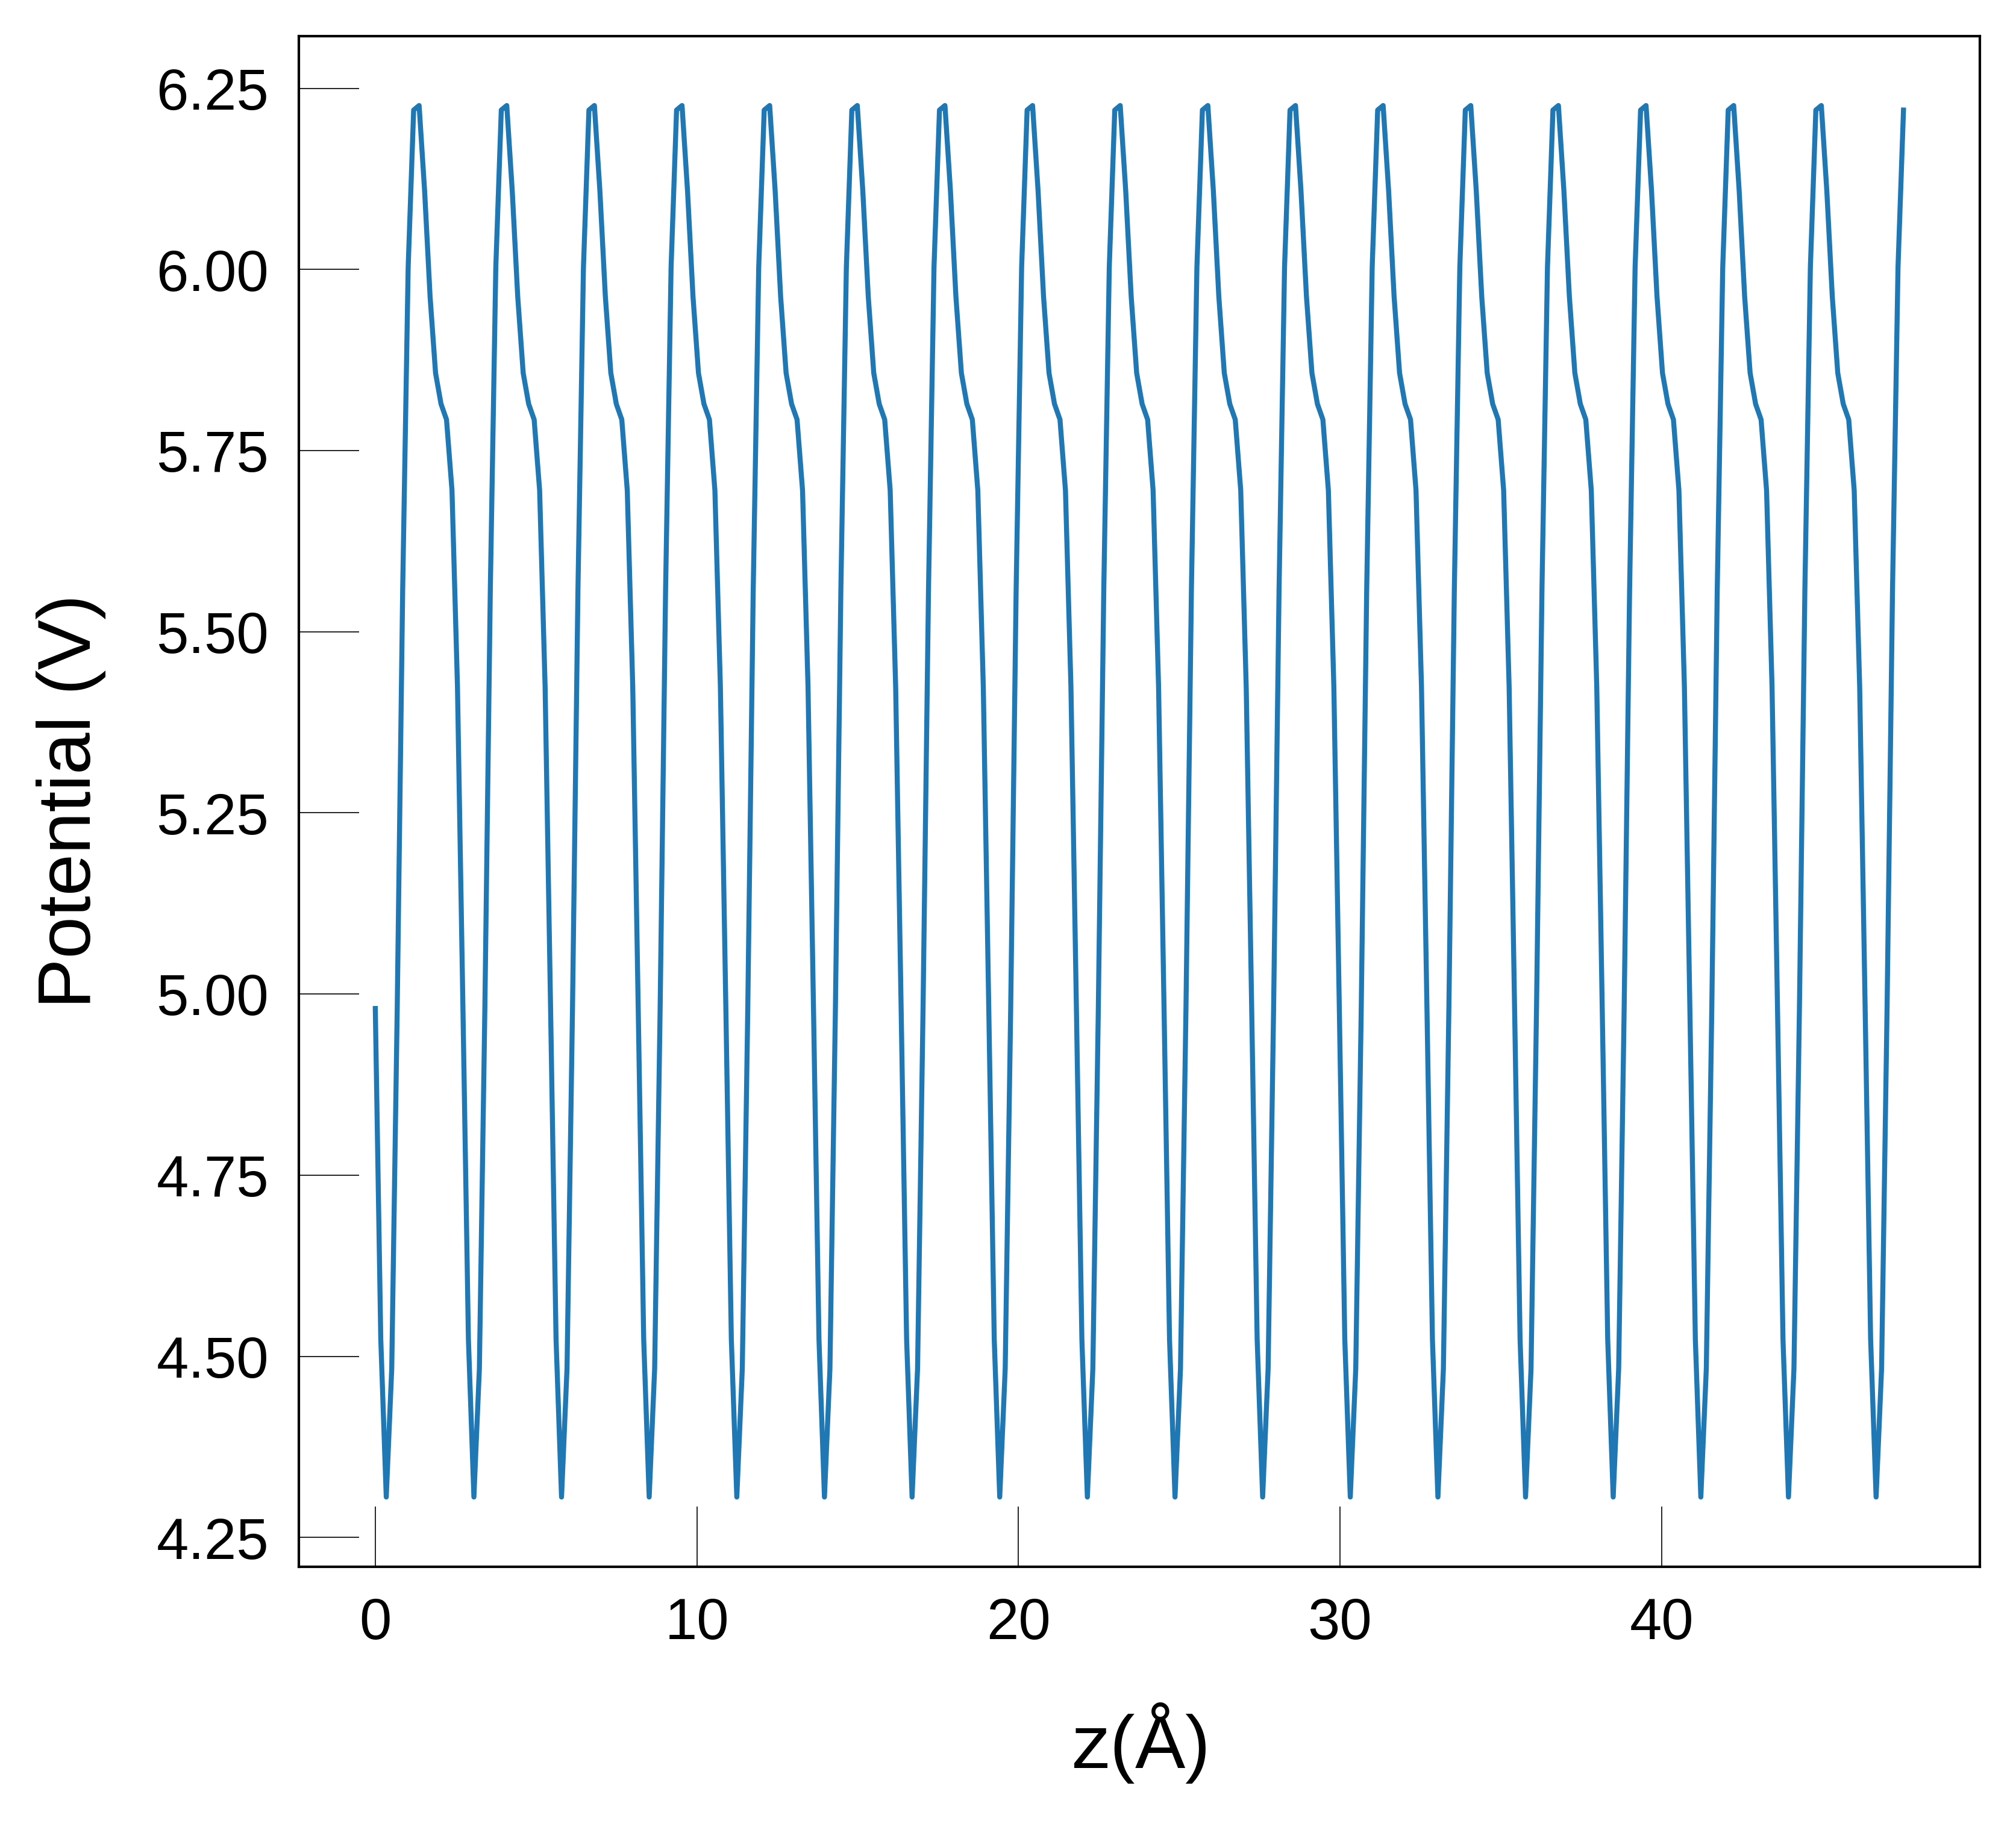

In [26]:
## PLOTTING
plt.plot(abscissa, cubes_potential)
plt.xlabel("$z (\AA)$")
plt.ylabel("Potential (V)") #(POINT: Fixed the axis title)
plt.savefig(img_file)

##SAVING
df = pd.DataFrame.from_dict({'Potential':cubes_potential},orient='index')
df = df.transpose()
df.to_csv(output_file)

## Plotting the Onsite (Hartree) Potential 

The Hartree potential is the electrostatic potential from a given electron charge density. The code below is an example of how the package calculates and plots the onsite (Hartree) potential.


### Imports and Inputs

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
import ase
import pandas as pd
from ase.io import write
from ase.io import vasp
import macrodensity as md

## INPUT SECTION
potential_file = 'LOCPOT.test'
coordinate_file = 'POSCAR.test'
species = "Zn"
sample_cube = [5,5,5]
output_file = 'OnSitePotential.csv'
img_file = 'OnSitePotential.png'

### Getting and calculating potentials

In [29]:
## GETTING POTENTIALS
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(potential_file)
vector_a,vector_b,vector_c,av,bv,cv = md.matrix_2_abc(Lattice)
resolution_x = vector_a/NGX
resolution_y = vector_b/NGY
resolution_z = vector_c/NGZ
grid_pot, electrons = md.density_2_grid(vasp_pot,NGX,NGY,NGZ)
grad_x,grad_y,grad_z = np.gradient(grid_pot[:,:,:],resolution_x,resolution_y,resolution_z)
coords = ase.io.vasp.read_vasp(coordinate_file)
scaled_coords = coords.get_scaled_positions()
symbols = coords.get_chemical_symbols()
ox_coords = []

for i, atom in enumerate(coords):
    if symbols[i] == species:
        ox_coords.append(scaled_coords[i])
grid_position = np.zeros(shape=(3))
potentials_list = []
i = 0
num_bins = 20
for coord in ox_coords:
    i = i + 1
    grid_position[0] = coord[0]
    grid_position[1] = coord[1]
    grid_position[2] = coord[2]
    cube = sample_cube
    origin = [grid_position[0]-2,grid_position[1]-2,grid_position[2]-1]
    travelled = [0,0,0]
    cube_potential, cube_var = md.volume_average(origin,cube,grid_pot,NGX,NGY,NGZ)
    potentials_list.append(cube_potential)

Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13


### Plotting and saving potentials

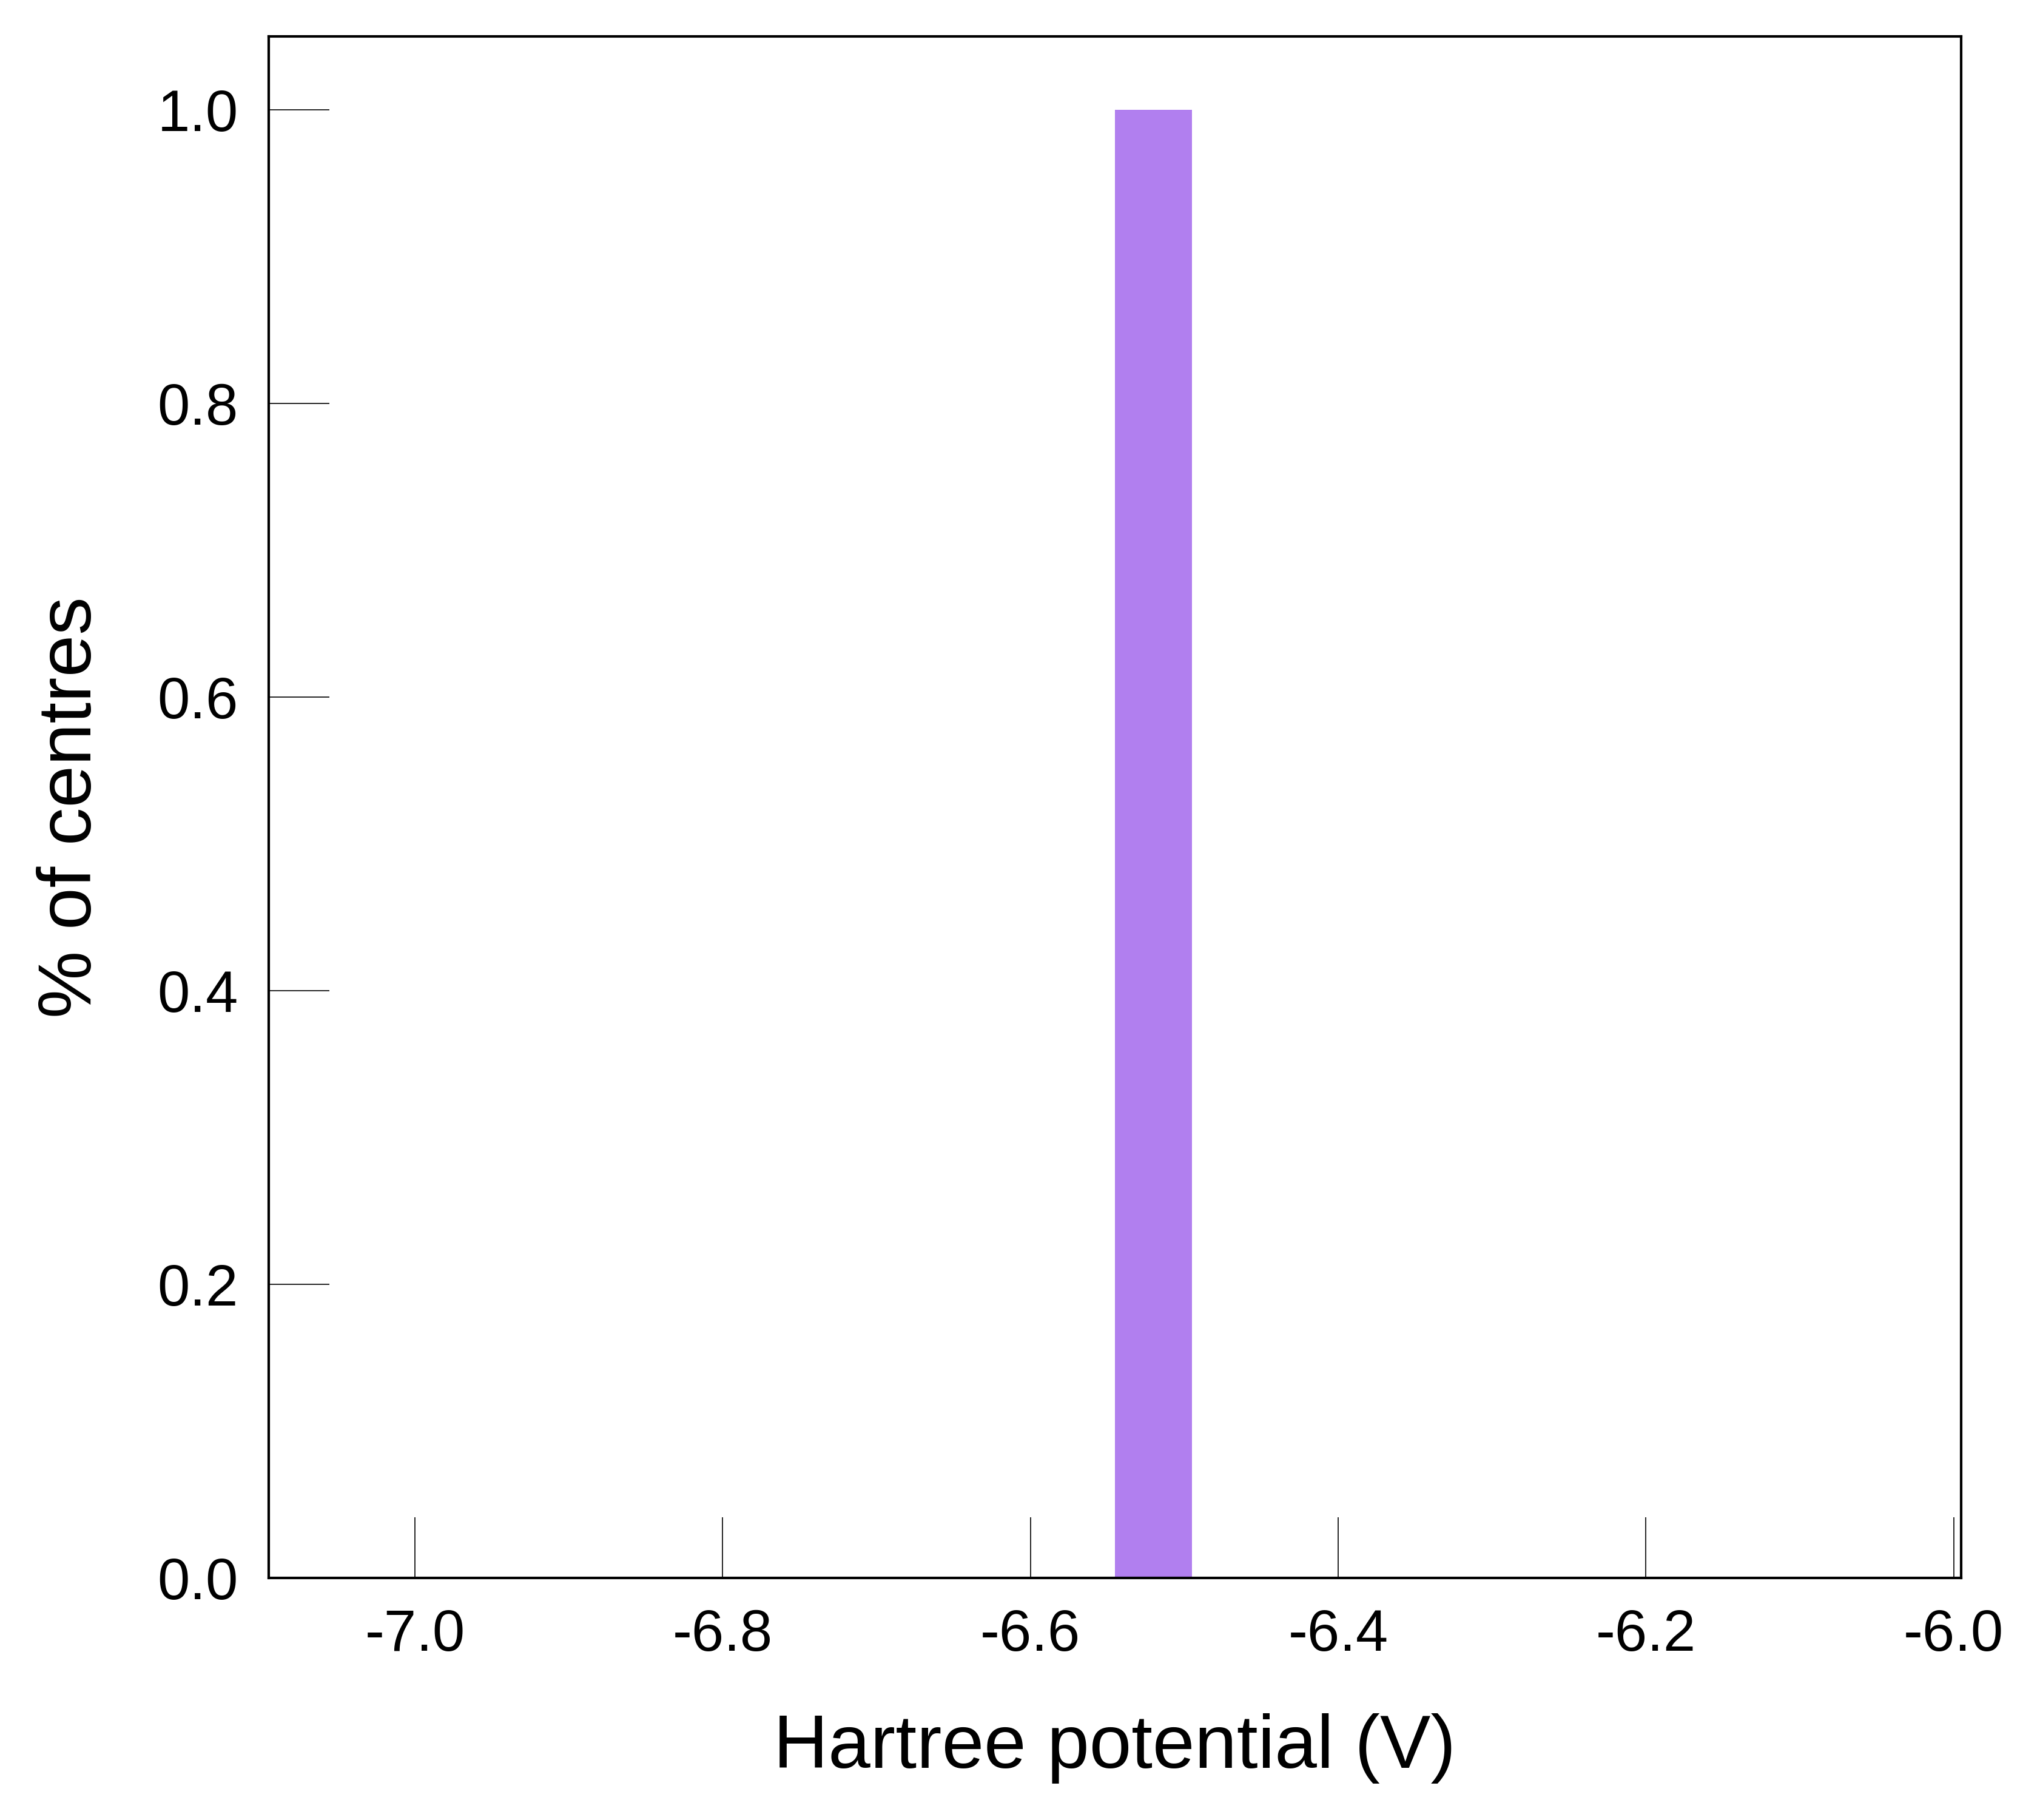

In [30]:
## PLOTTING
n, bins, patches = plt.hist(potentials_list, num_bins, facecolor='#6400E1', alpha=0.5)
plt.xlabel('Hartree potential (V)')
plt.ylabel('% of centres')
plt.savefig(img_file)

## SAVING
df = pd.DataFrame.from_dict({'Potential':potentials_list},orient='index')
df = df.transpose()
df.to_csv(output_file)

## Calculating the Spherical Average around a given point in a material

The code below calculates the spherical average of potential values within a specified cube around a given point using the macrodensity module. The script reads potential data from a VASP LOCPOT input file, extracts grid information, and calculates grid parameters. It then employs the md.volume_average function to compute the spherical average within the defined cube region, with the origin point and cube size provided. The resulting cube potential and cube variance values are printed in a formatted manner, returning the averaged potential distribution. This script is designed to facilitate the analysis of potential distributions within defined spatial regions.

### Input Section

In [39]:
cube_size = [2,2,2]
cube_origin = [0.5,0.5,0.5]
travelled = [0,0,0]
input_file = 'LOCPOT.test'

### Getting potential and printing the potential and variance values

In [40]:
## GETTING POTENTIAL
vasp_pot, NGX, NGY, NGZ, Lattice = md.read_vasp_density(input_file)
grid_pot, electrons = md.density_2_grid(vasp_pot, NGX, NGY, NGZ)

cube_pot, cube_var = md.volume_average(
    origin=cube_origin,
    cube=cube_size,
    grid=grid_pot,
    nx=NGX,
    ny=NGY,
    nz=NGZ,
    travelled=travelled
)

## PRINTING
print("Potential            Variance")
print("--------------------------------")
print(cube_pot,"   ", cube_var)


Reading header information...
Reading 3D data using Pandas...
Average of the potential =  -4.0478731477833207e-13
Potential            Variance
--------------------------------
6.5579496029375     1.8665165271901357e-05
